### Initialisation des hyperparamètres

In [1]:
from os import environ

environ['optimizer'] = 'Adam'
environ['num_workers']= '2'
environ['batch_size']= str(512)
environ['batch_norm']= 'True'
environ['loss_func']='MAPE'
environ['layers'] = '500 300 120 80 30'
environ['dropouts'] = '0.3 '*5
environ['log'] = 'False'
environ['weight_decay'] = '0.01'
environ['cuda_device'] ='cuda:1'
environ['dataset'] = 'data/conv.pkl'

%run utils.ipynb
plt.rcParams['figure.figsize'] = [40, 30]

### Chargement des données

In [2]:
ds = DatasetFromPkl(dataset, maxsize=None, log=log)

dl = DataLoader(ds, batch_size=batch_size,
                        sampler=SubsetRandomSampler(range(len(ds))),
                         num_workers=num_workers)

db = fai.basic_data.DataBunch(dl, dl, device=device)

train_dl = dl

### Creation du modèle

In [3]:
input_size = train_dl.dataset.X.shape[1]
output_size = train_dl.dataset.Y.shape[1]


model = Model_BN(input_size, output_size, hidden_sizes=layers_sizes, drops=drops)

criterion = mape_criterion

l = fai.Learner(db, model, loss_func=criterion)    

### Architecture du modèle

Feedforward. Equations d'une couche interne l:

$$Z_l = W_l A_{l-1} + b_l$$

$$A_l = ReLU(Z_l)$$

$$A_l = Batch\_norm_{\alpha,\beta}(A_l)$$


où: $$ReLU(x) = max(0, x)$$



### Entrainement du modèle
Taux d'apprentissage $$\alpha = 0.001$$
Nombre d'itérations = 50

In [4]:
alpha = 1e-03
epochs = 50

In [5]:
l.fit_one_cycle(epochs, alpha)

epoch,train_loss,valid_loss
1,102.136902,36.319344
2,95.399834,90.673561
3,95.601974,120.309677
4,94.530807,122.710693
5,94.068588,108.351311
6,94.731300,89.999863
7,94.989784,73.612503
8,94.931061,55.571342
9,94.775948,46.092339
10,95.678490,47.011852


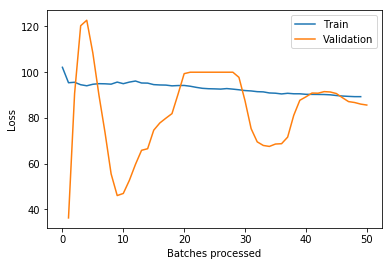

In [6]:
l.recorder.plot_losses()

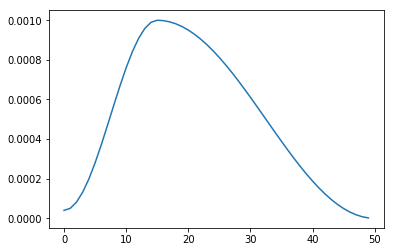

In [7]:
l.recorder.plot_lr()

In [8]:
l = l.load(f"training_tuning")

In [9]:

train_df = get_results_df(train_dl, l.model)
df = train_df
df = df[1:]

In [11]:
df[:][['index', 'prediction']].sort_values(by='prediction', ascending=False)

,index,prediction
58,58,0.580466
54,54,0.552432
77,77,0.523198
44,44,0.514327
31,31,0.470662
14,14,0.459485
3,3,0.457847
88,88,0.456971
28,28,0.454145
33,33,0.435479


In [12]:
ds.schedules[58].schedule_list

[{'type': 'interchange', 'params': [0, 5], 'factors': None},
 {'type': 'tiling', 'params': [-1, -1, -1], 'factors': [-1, -1, -1]},
 {'type': 'unrolling', 'params': None, 'factors': [16]}]

Real speedup of schedule 7  : s = 1.29

Real speedup of schedule 19 : s = 1.73

### Convolution

In [26]:
ds.programs[0].dict_repr

{'seed': 10243,
 'type': 5,
 'loops': {'n': 3,
  'loops_array': [{'loop_id': 0,
    'parent': -1,
    'position': 0,
    'loop_it': 0,
    'assignments': {'n': 0, 'assignments_array': []}},
   {'loop_id': 1,
    'parent': 0,
    'position': 0,
    'loop_it': 5,
    'assignments': {'n': 0, 'assignments_array': []}},
   {'loop_id': 2,
    'parent': 1,
    'position': 0,
    'loop_it': 6,
    'assignments': {'n': 1,
     'assignments_array': [{'id': 0, 'position': 0}]}}]},
 'computations': {'n': 1,
  'computations_array': [{'comp_id': 0,
    'lhs_data_type': 'p_int32',
    'loop_iterators_ids': [0, 5, 6],
    'operations_histogram': [[0, 0, 0, 0],
     [0, 0, 0, 0],
     [0, 0, 0, 0],
     [0, 0, 0, 0],
     [0, 0, 0, 0],
     [0, 0, 0, 0],
     [0, 0, 0, 0]],
    'rhs_accesses': {'n': 18,
     'accesses': [{'comp_id': 1, 'access': [[0, 1, 0, 0], [0, 0, 1, 0]]},
      {'comp_id': 2, 'access': [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]]},
      {'comp_id': 1, 'access': [[0, 1, 0, 0], [0, 0,

In [ ]:
conv_dataloader = dl

In [20]:
df = get_results_df(conv_dataloader, l.model)

In [24]:
df[:][['index', 'prediction']].sort_values(by='prediction', ascending=False)

,index,prediction,target
58,58,0.580466,1.871575
54,54,0.552432,1.885073
77,77,0.523198,0.331829
44,44,0.514327,0.266633
31,31,0.470662,0.317572
14,14,0.459485,0.265213
3,3,0.457847,0.343183
88,88,0.456971,0.263550
28,28,0.454145,0.253250
33,33,0.435479,0.711308


In [27]:
ds.schedules[54].schedule_list

[{'type': 'interchange', 'params': [0, 5], 'factors': None},
 {'type': 'tiling', 'params': [-1, -1, -1], 'factors': [-1, -1, -1]},
 {'type': 'unrolling', 'params': None, 'factors': [1]}]

Real speedup of schedule 58 : s = 1.87

Real speedup of schedule 54  : s = 1.89